In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import f1_score
from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [8]:
# Load Data
train_raw = pd.read_csv('../Data/KDDCUP99/train.csv')
test_raw = pd.read_csv('../Data/KDDCUP99/test.csv')
print(train_raw.shape)
print(test_raw.shape)

# Seperate label and Drop ID
def LabelEncode(x):
    if x == 'normal.':
        return 0
    else:
        return 1
train_X = train_raw.drop(['type'], axis=1).select_dtypes(include='number')
print(train_X.shape)
test_X = test_raw.drop(['type'], axis=1).select_dtypes(include='number')
print(test_X.shape)
train_Y = train_raw['type'].apply(LabelEncode)
test_Y = test_raw['type'].apply(LabelEncode)

# Normalize data with min, max of training data
test_X1 = (test_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
train_X1 = (train_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))

test_X1[test_X1 < 0] = 0
test_X1[test_X1 > 1] = 1

train_X1.fillna(0, inplace=True)
test_X1.fillna(0, inplace=True)

(494021, 42)
(311029, 42)
(494021, 38)
(311029, 38)


In [9]:
features_lr = ['count', 'logged_in']
features_gb = ['count', 'logged_in', 'dst_bytes']
features_nn = ['count', 'logged_in']

In [6]:
# hyperparameters to search
solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values = [100, 10, 1.0, 0.1, 0.01]
max_iter = [100, 300, 500, 1000, 5000, 10000]
grid = dict(solver=solvers, C=c_values, max_iter=max_iter)
# grid search
model_lr = LogisticRegression(random_state=0, n_jobs=-1)
cv = RepeatedStratifiedKFold(random_state=0)
grid_search = GridSearchCV(estimator=model_lr, param_grid=grid, scoring='f1', cv=cv, n_jobs=-1, error_score=0)
grid_result = grid_search.fit(train_X1, train_Y)
# get the best result
print("Best: %f using %s with all features" % (grid_result.best_score_, grid_result.best_params_))
grid_result = grid_search.fit(train_X1[features_lr], train_Y)
# get the best result
print("Best: %f using %s with selected features" % (grid_result.best_score_, grid_result.best_params_))

c:\Users\ccis229c\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


Best: 0.997867 using {'C': 100, 'max_iter': 100, 'solver': 'liblinear'} with all features


c:\Users\ccis229c\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


Best: 0.988097 using {'C': 0.01, 'max_iter': 100, 'solver': 'liblinear'} with selected features


In [10]:
model_lr = LogisticRegression(solver='liblinear', C=100, max_iter=100, random_state=0)
model_lr.fit(train_X1, train_Y)
predict = model_lr.predict(test_X1)
print(f1_score(test_Y, predict))

0.9481575374987187


In [11]:
model_lr = LogisticRegression(solver='liblinear', C=0.01, max_iter=100, n_jobs=-1, random_state=0)
model_lr.fit(train_X1[features_lr], train_Y)
predict = model_lr.predict(test_X1[features_lr])
print(f1_score(test_Y, predict))

c:\Users\ccis229c\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


0.9412706012801775


In [7]:
# hyperparameters to search
n_estimators = [1000, 3000, 5000, 10000]
learning_rate = [0.01, 0.1]
subsample = [0.7, 0.8, 0.9, 1.0]
max_depth = [7, 9, 11]
grid = dict(n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample, max_depth=max_depth)

model_gb = GradientBoostingClassifier(random_state=0)
grid_search = GridSearchCV(estimator=model_gb, param_grid=grid, scoring='f1', cv=cv, n_jobs=-1, error_score=0)
grid_result = grid_search.fit(train_X1, train_Y)
# get the best result
print("Best: %f using %s with all features" % (grid_result.best_score_, grid_result.best_params_))
grid_result = grid_search.fit(train_X1[features_gb], train_Y)
# get the best result
print("Best: %f using %s with selected features" % (grid_result.best_score_, grid_result.best_params_))
unpatch_sklearn()

In [12]:
model_gb = GradientBoostingClassifier(learning_rate=0.1, max_depth=9, n_estimators=1000, subsample=1.0, random_state=0)
model_gb.fit(train_X1[features_gb], train_Y)
predict = model_gb.predict(test_X1[features_gb])
print(f1_score(test_Y, predict))

0.9459537560150266


In [13]:
model_gb = GradientBoostingClassifier(learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.7, random_state=0)
model_gb.fit(train_X1, train_Y)
predict = model_gb.predict(test_X1)
print(f1_score(test_Y, predict))

0.952293604815139


In [14]:
from tensorflow.python.keras import Sequential, layers, optimizers, losses, metrics, callbacks, backend

In [15]:
def ModelCreate(input_shape):
    model = Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])
    return model

In [16]:
# early stopping to prevent overfitting
callback = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30, min_delta=0.001, restore_best_weights=True)
# model training
model_nn = ModelCreate((len(features_nn),))
history = model_nn.fit(train_X1[features_nn], train_Y, batch_size=1024, validation_split=0.2, epochs=1000, use_multiprocessing=True, verbose=1)

Epoch 1/1000
386/386 [==============================] - 3s 5ms/step - loss: 0.1106 - binary_accuracy: 0.9645 - val_loss: 0.0435 - val_binary_accuracy: 0.9925
Epoch 2/1000
386/386 [==============================] - 2s 4ms/step - loss: 0.0731 - binary_accuracy: 0.9788 - val_loss: 0.0451 - val_binary_accuracy: 0.9923
Epoch 3/1000
386/386 [==============================] - 2s 5ms/step - loss: 0.0721 - binary_accuracy: 0.9792 - val_loss: 0.0459 - val_binary_accuracy: 0.9922
Epoch 4/1000
386/386 [==============================] - 2s 5ms/step - loss: 0.0715 - binary_accuracy: 0.9792 - val_loss: 0.0417 - val_binary_accuracy: 0.9925
Epoch 5/1000
386/386 [==============================] - 2s 5ms/step - loss: 0.0709 - binary_accuracy: 0.9793 - val_loss: 0.0436 - val_binary_accuracy: 0.9923
Epoch 6/1000
386/386 [==============================] - 2s 5ms/step - loss: 0.0700 - binary_accuracy: 0.9794 - val_loss: 0.0436 - val_binary_accuracy: 0.9923
Epoch 7/1000
386/386 [==============================

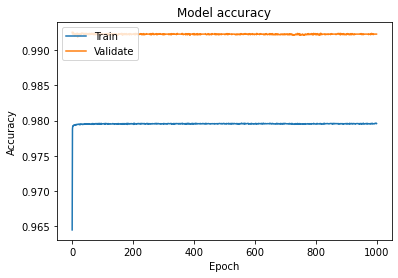

In [17]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

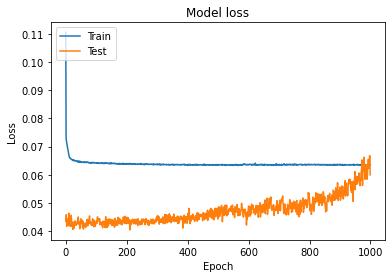

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
predicts = model_nn.predict(test_X1[features_nn], batch_size=1024, use_multiprocessing=True)
predicts = np.where(predicts < 0.5, 0, 1)
print(f1_score(test_Y, predicts))

0.9416748454421152


In [21]:
# model training
model_nn = ModelCreate((train_X1.shape[1],))
history = model_nn.fit(train_X1, train_Y, batch_size=1024, validation_split=0.2, epochs=100, callbacks=[callback], use_multiprocessing=True, verbose=1)

Epoch 1/100
386/386 [==============================] - 3s 6ms/step - loss: 0.0806 - binary_accuracy: 0.9686 - val_loss: 0.0131 - val_binary_accuracy: 0.9964
Epoch 2/100
386/386 [==============================] - 2s 5ms/step - loss: 0.0108 - binary_accuracy: 0.9968 - val_loss: 0.0099 - val_binary_accuracy: 0.9978
Epoch 3/100
386/386 [==============================] - 2s 5ms/step - loss: 0.0061 - binary_accuracy: 0.9983 - val_loss: 0.0086 - val_binary_accuracy: 0.9982
Epoch 4/100
386/386 [==============================] - 2s 5ms/step - loss: 0.0050 - binary_accuracy: 0.9986 - val_loss: 0.0090 - val_binary_accuracy: 0.9983
Epoch 5/100
386/386 [==============================] - 2s 5ms/step - loss: 0.0044 - binary_accuracy: 0.9987 - val_loss: 0.0093 - val_binary_accuracy: 0.9983
Epoch 6/100
386/386 [==============================] - 2s 5ms/step - loss: 0.0040 - binary_accuracy: 0.9988 - val_loss: 0.0088 - val_binary_accuracy: 0.9984
Epoch 7/100
386/386 [==============================] - 2s 

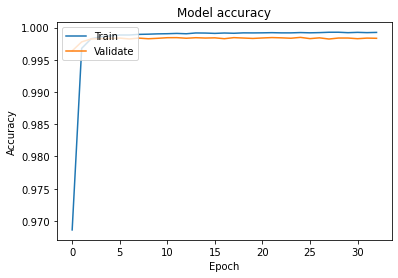

In [22]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

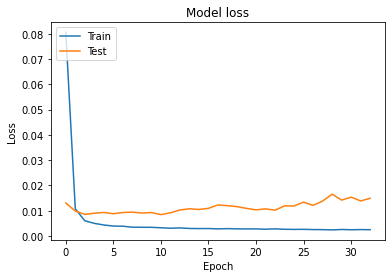

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [25]:
predicts = model_nn.predict(test_X1, batch_size=1024, use_multiprocessing=True)
predicts = np.where(predicts < 0.5, 0, 1)
print(f1_score(test_Y, predicts))

0.9500332999985386
